The descriptors seems to be too local and are not able to distinguish general properties able to cluster cells. The cluster that are generated are always randomly distributed in space. 

In [1]:
import numpy as np
from numpy import linalg as LA
from scipy.sparse import csc_matrix,coo_matrix
from scipy.sparse.linalg import svds, eigs
from sklearn.decomposition import PCA,TruncatedSVD
import pickle
import pandas as pd
from random import randint
import random

import umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AffinityPropagation, MeanShift
from sklearn.preprocessing import MinMaxScaler
import kmapper as km
from kmapper.cover import Cover
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import networkx as nx
from community import best_partition # this is not part of networkx

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
from scipy import ndimage
import imageio
import plotly
import plotly.graph_objs as go


import os

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax    
def embedding(data,dim):
    projection = mapper.fit_transform(data, projection=umap.UMAP(n_components=dim, n_neighbors=200, 
                                             a=None, angular_rp_forest=False, b=None, init='spectral',
                                           learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
                                           metric_kwds=None, min_dist=0.1, n_epochs=500,
                                           negative_sample_rate=10, random_state=47,
                                           repulsion_strength=1.0, set_op_mix_ratio=0.5, spread=0.25,
                                           target_metric='categorical', target_metric_kwds=None,
                                           target_n_neighbors=-1, target_weight=0.5, transform_queue_size=10.0,
                                           transform_seed=42, verbose=False))
    return projection

In [2]:
'''Loading the data'''
widths = []
heights = []
target = []

directory = '/home/garner1/Work/dataset/cellImages/Dataset_Image52/Nuclei_Image52'
for img in os.listdir(directory):
    filename = os.path.join(directory, img)
    img = imageio.imread(filename)
    rmin, rmax, cmin, cmax = bbox(img)
    width = rmax-rmin
    height = cmax-cmin
    widths.append(width)
    heights.append(height)
    target.append(0)

Mwidths = max(widths)
Mheights = max(heights)

'''Boxing all images homogeneously'''
# nullimg = np.zeros(Mwidths,Mheights)
images = []
directory = '/home/garner1/Work/dataset/cellImages/Dataset_Image52/Nuclei_Image52'
for img in os.listdir(directory):
    filename = os.path.join(directory, img)
    img = imageio.imread(filename)
    rmin, rmax, cmin, cmax = bbox(img)
    padwidth = int(Mwidths-(rmax-rmin))
    padheight = int(Mheights-(cmax-cmin))
    newimg = np.pad(img[rmin:rmax,cmin:cmax],((0,padwidth),(0,padheight)),'constant', constant_values=(0))
    images.append(newimg)

print(len(images))

1699


In [179]:
import cv2

# defining feature extractor that we want to use
extractor = cv2.ORB_create()

def features(image, extractor):
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints, descriptors

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

img = np.pad(images[0], 50, pad_with, padder=0)   # pad the image with enough zeros to be process by ORB
keypoints, descriptors = features(img, extractor)
# data = np.dot(descriptors.T,descriptors).reshape((1,32*32))
for img in images[1:]:
    img = np.pad(img, 50, pad_with, padder=0)   # pad the image with enough zeros to be process by ORB
    keypoints, descriptors = features(img, extractor)
    
    data = np.vstack((data,np.dot(descriptors.T,descriptors).reshape((1,32*32))))
    
#     keypoints_without_size = cv2.drawKeypoints(img, keypoints, keypoints_without_size, color = (0, 255, 0))
#     keypoints_without_size = cv2.cvtColor(keypoints_without_size, cv2.COLOR_BGR2RGB)
#     keypoints_without_size = cv2.cvtColor(keypoints_without_size, cv2.COLOR_RGB2GRAY)

#     keypoints_with_size = cv2.drawKeypoints(img, keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#     keypoints_with_size = cv2.cvtColor(keypoints_with_size, cv2.COLOR_BGR2RGB)
#     keypoints_with_size = cv2.cvtColor(keypoints_with_size, cv2.COLOR_RGB2GRAY)
    
#     # Display image with and without keypoints size
#     fx, plots = plt.subplots(1, 2, figsize=(20,10))

#     plots[0].set_title("Image")
#     plots[0].imshow(img, cmap='gray')

#     plots[1].set_title("Train keypoints Without Size")
#     plots[1].imshow(keypoints_without_size, cmap='gray')
    
#     plots[2].set_title("Train keypoints With Size")
#     plots[2].imshow(keypoints_with_size, cmap='gray')


    # Print the number of keypoints detected in the training image
#     print("Number of Keypoints Detected In The Training Image: ", len(keypoints))    
#     print("Number of Keypoints Detected In The Training Image: ", descriptors.shape)    

In [180]:
print data.shape
data = PCA(n_components=100).fit_transform(data)
print data.shape

(1699, 1024)
(1699, 100)


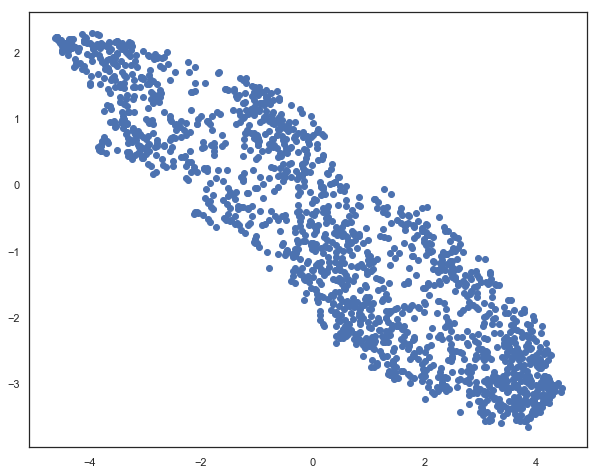

In [181]:
'''2D visualization of annotated data'''
d2_embedding = umap.UMAP(n_neighbors=10,min_dist=0.0,n_components=2,random_state=42).fit_transform(data)
#####
sns.set(style='white', rc={'figure.figsize':(10,8)})
plt.scatter(d2_embedding[:, 0], d2_embedding[:, 1]);

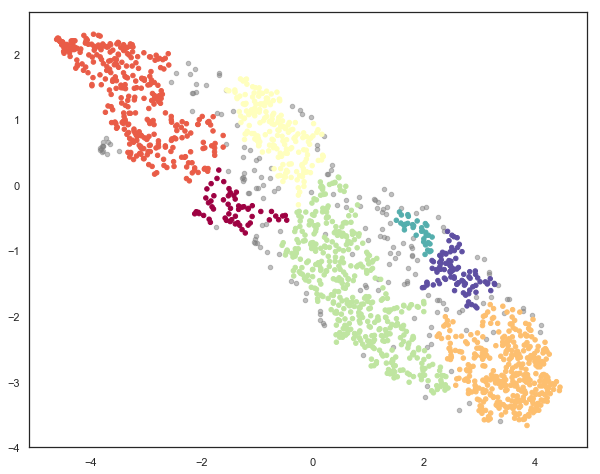

In [182]:
'''
HDBSCAN clusters in 2D
low min sample size seems to refuce unclustered data;
larger min cluster size decrease cluster numbers
'''
d2_labels = hdbscan.HDBSCAN(min_samples=3,min_cluster_size=30).fit_predict(d2_embedding)

sns.set(style='white', rc={'figure.figsize':(10,8)})
clustered = (d2_labels >= 0)
plt.scatter(d2_embedding[~clustered, 0],
            d2_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=20,
            alpha=0.5)
plt.scatter(d2_embedding[clustered, 0],
            d2_embedding[clustered, 1],
            c=d2_labels[clustered],
            s=20,
            cmap='Spectral');

In [183]:
'''3D visualization of annotated data'''
d3_embedding = umap.UMAP(n_neighbors=10,min_dist=0.0,n_components=3,random_state=42).fit_transform(data)
######
# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()
trace = go.Scatter3d(
    x=d3_embedding[:,0],  # <-- Put your data instead
    y=d3_embedding[:,1],  # <-- Put your data instead
    z=d3_embedding[:,2],  # <-- Put your data instead
    mode='markers',
    marker=dict(color=1,size=3, opacity=1)
)
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)
mydata = [trace]
plot_figure = go.Figure(data=mydata, layout=layout)
plotly.offline.iplot(plot_figure)

In [184]:
'''
HDBSCAN clusters in 3D
low min sample size seems to refuce unclustered data;
larger min cluster size decrease cluster numbers
PCA reduction might not be a good idea because shape space is non-linear and the linear reduction could distort distances and later clustering
'''
d3_labels = hdbscan.HDBSCAN(min_samples=3,min_cluster_size=50).fit_predict(d3_embedding)

import plotly.graph_objects as go
fig = go.Figure()
size = 2
for cluster in set(d3_labels):
    clustered = (d3_labels == cluster)
    fig.add_trace(go.Scatter3d(
        x=d3_embedding[clustered,0],  # <-- Put your data instead
        y=d3_embedding[clustered,1],  # <-- Put your data instead
        z=d3_embedding[clustered,2],  # <-- Put your data instead
        name="cluster "+str(cluster),
        mode="markers",
        marker=dict(color=cluster+1,size=size, opacity=1)
    ))
fig.update_layout(title_text="HDBSCAN clusters in 3D",
                  title_font_size=30)
fig.show()
##########
clustered = (d3_labels >= 0)
print('The percentage of clustered data points is '+str(np.sum(clustered) *1.0/ data.shape[0]*100)+'%')


The percentage of clustered data points is 73.33725721012361%


In [185]:
directory = '/home/garner1/Work/dataset/cellImages/Dataset_Image52/images'
ind = 0
image_cluster = []
for img in os.listdir(directory):
    filename = os.path.join(directory, img)
    image_cluster.append((int(img.strip('.jpg')),d3_labels[ind]))
    ind += 1
    
import operator
image_cluster.sort(key = operator.itemgetter(0))
ordered_d3_labels = np.array([cluster[1] for cluster in image_cluster])
# print image_cluster[:20]
# print ordered_d3_labels[:20]

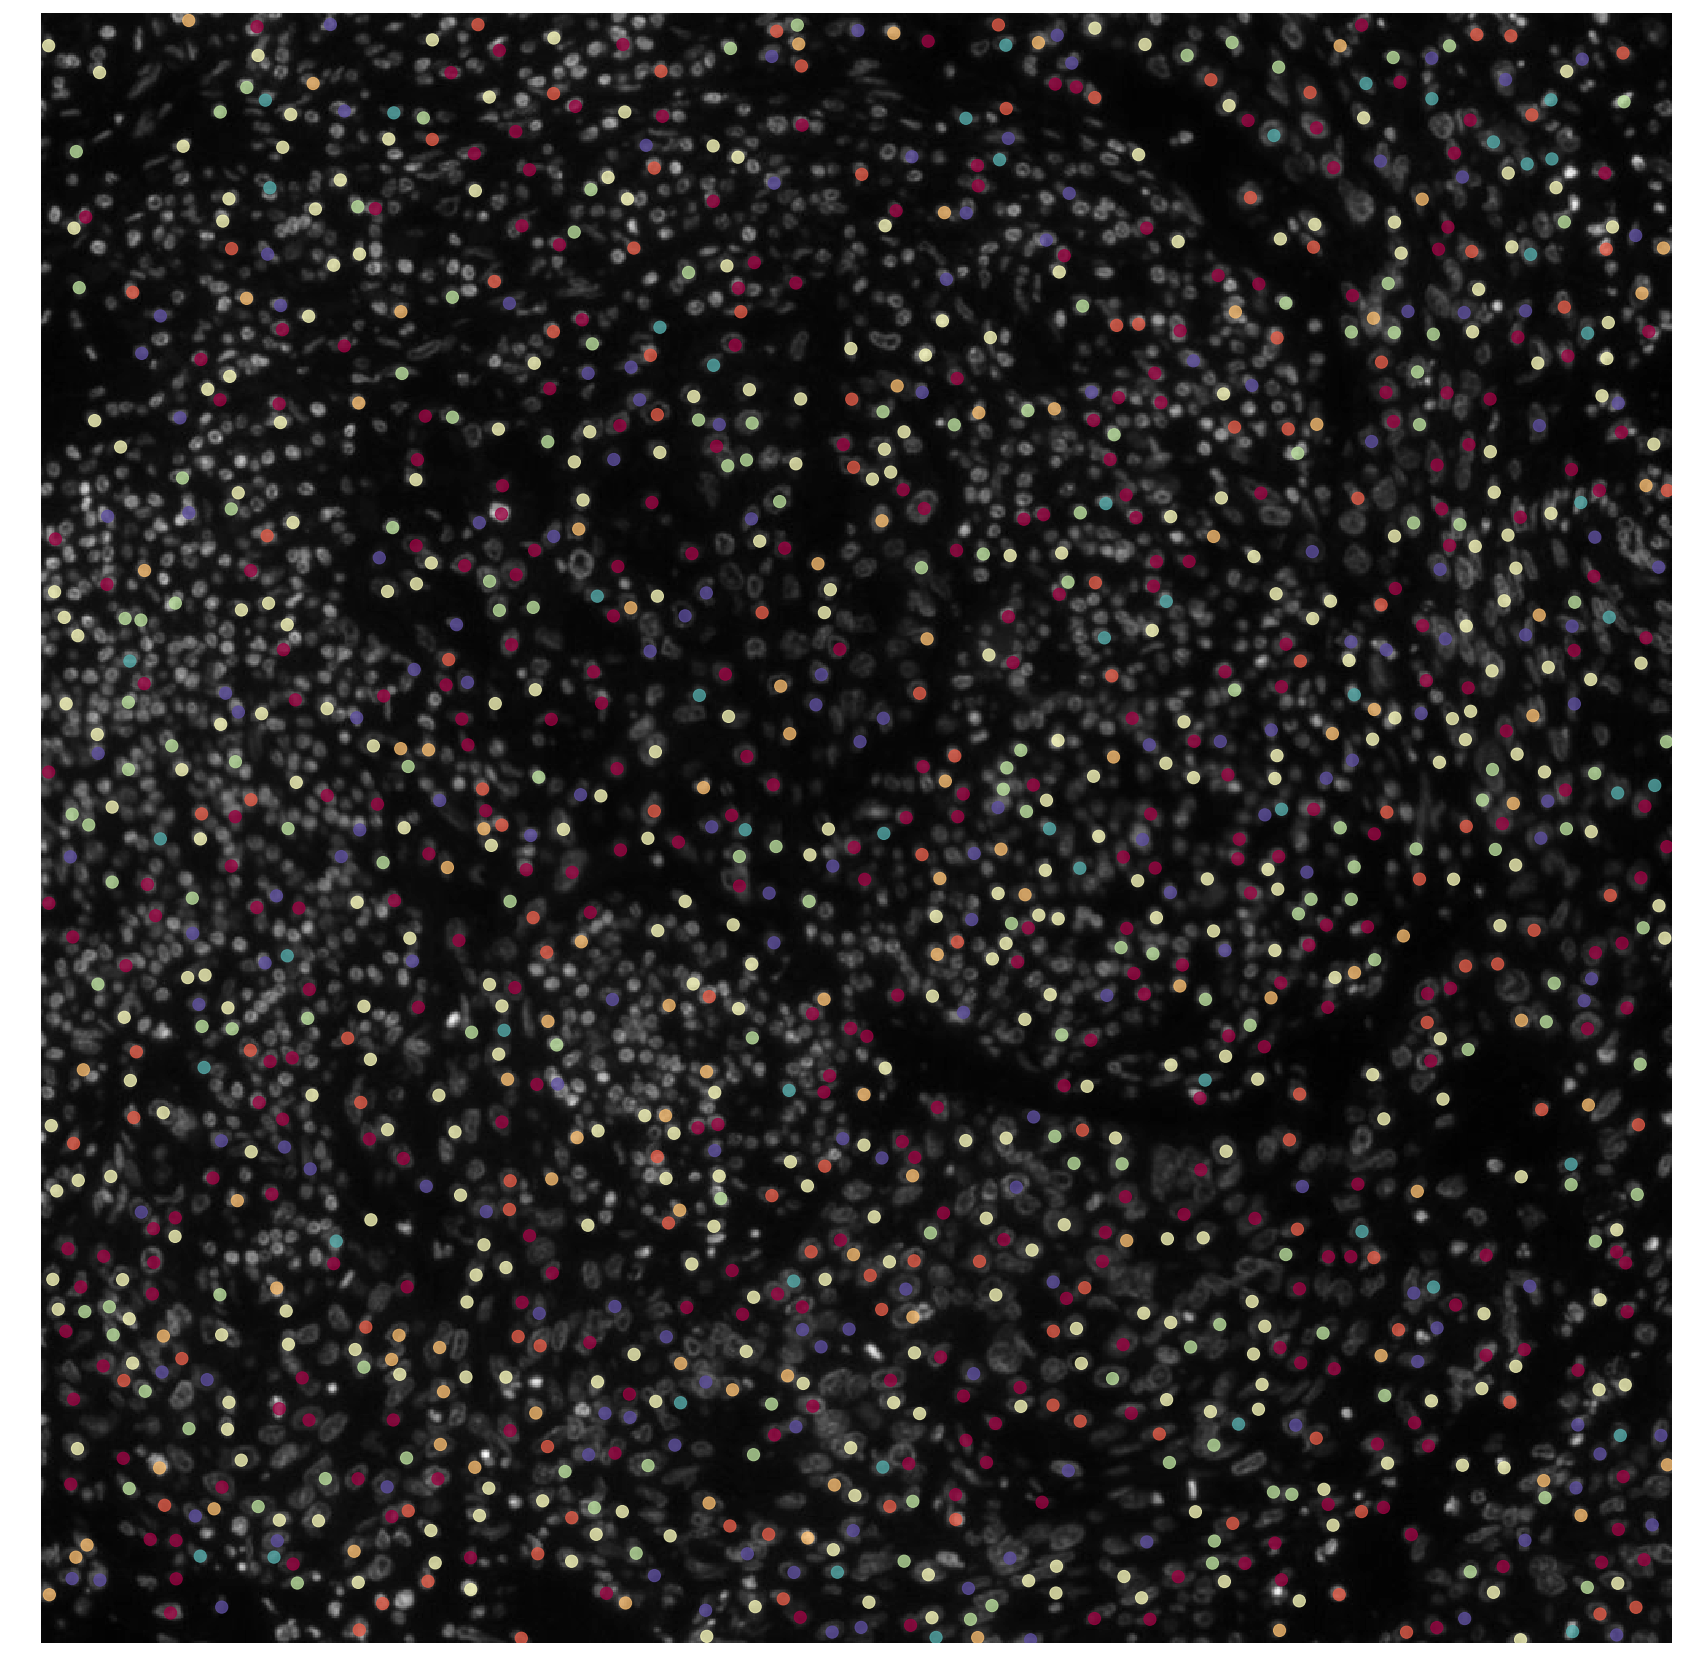

In [186]:
import csv
with open('/home/garner1/Work/dataset/cellImages/Dataset_Image52/properties.csv', 'r') as f:
    properties = list(csv.reader(f, delimiter=','))
properties = np.array(properties)

image = imageio.imread('~/Work/dataset/cellImages/Dataset_Image52/iMS266_20190426_001.sub52.jpg')
sns.set(style='white', rc={'figure.figsize':(50,30)})
xy = properties[1:,1:3]
labeled_cells = np.hstack((xy,ordered_d3_labels.reshape((xy.shape[0], 1))))

plt.scatter(labeled_cells[clustered,0].astype(np.float),
            labeled_cells[clustered,1].astype(np.float),
            c=labeled_cells[clustered,2],
            s=150,
            cmap='Spectral',
            alpha=0.75);
plt.imshow(image,cmap='gray')
plt.axis('off')
plt.show()


In [53]:
'''Get the node2vec representation of the centroid from each segmented cell. 
Use it together with the intensity array as input for the UMAP dimensionality reduction.
Spatial contect + local intensity information'''

(1024, 1024)

In [33]:
np.savetxt("clusters.csv", d3_labels.astype(int), delimiter=",", fmt='%i')